# Functional connectivity analysis of EEG signals

Medusa's `connectivity` module provides a suite of methods for analyzing the **relationships between signals recorded at different EEG sensors**. These techniques offer a broader view of brain dynamics by quantifying how different regions interact functionally over time.

Each method returns an **adjacency matrix**, where each element represents the connectivity value between two channels or sources. These matrices are essential for visualizing and interpreting large-scale brain network organization.

The module includes two main types of connectivity measures: those based on **signal phase** and those based on **signal amplitude**. Phase-based methods capture the synchrony between oscillatory phases, while amplitude-based methods measure correlations in signal intensity over time.

This notebook provides a step-by-step introduction to the main functions of the `connectivity` module through practical examples. You will learn how to:

- Preprocess raw EEG recordings
- Apply both phase- and amplitude-based connectivity metrics
- Generate and interpret connectivity matrices using Medusa's plotting tools

📘 *For reference, see the [Medusa documentation](https://docs.medusabci.com/kernel/1.4/getstarted.php).*

## Imports

Install dependencies and clone the repository to download the signals that
will be used in this notebook

<div class="alert alert-block alert-danger">
Important: execute the following cell **only** if you're using Google Collab!
</div>

In [ ]:
!pip install medusa-kernel
!git clone https://github.com/medusabci/medusa-tutorials.git

Import the modules that will be used in this notebook.

In [7]:
# General imports
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
from matplotlib import colors, cm
import numpy as np

# Medusa imports
from medusa import components
from medusa import transforms
from medusa.frequency_filtering import FIRFilter
from medusa.spatial_filtering import car
from medusa.connectivity import phase_connectivity,amplitude_connectivity
from medusa.epoching import get_epochs
from medusa.plots.head_plots import TopographicPlot, ConnectivityPlot

print('\n> All required packages were successfully imported')


Packages imported correctly!


## Load EEG recording

The recording used in this tutorial is an instance of the
`medusa.components.Recording` class, which stores all relevant metadata
about the experiment along with the recorded biosignals. The recording was
performed using the [Recorder](https://www.medusabci.com/market/rec/) app from MEDUSA Platform.

The recording contains a `medusa.meeg.EEG` object, which contains
the actual EEG signal, channel layout, sampling frequency, and other
acquisition details. We will import the sample recording and extract useful
metadata such as:
- The list of EEG channel labels
- The sampling frequency (`fs`)

This information is essential for preprocessing and feature extraction in the subsequent steps.

In [3]:
# Load one recording from the dataset
recording = components.Recording.load('rest_eeg/S01.rec.bson')

# Get the EEG signal and time-stamps vector from recording
signal = recording.eeg.signal.copy()
times = recording.eeg.times.copy()

# Get the EEG Channel set and sampling rate
ch_set = recording.eeg.channel_set
fs = recording.eeg.fs

# Print recording info
print('\n> Data exploration:')
print(f'\t- Sampling rate (Hz): {fs}')
print(f'\t- EEG channels: {ch_set.l_cha}')
print(f'\t- Signal duration (s): {len(times)/fs}')


> Data exploration:
	- Sampling rate (Hz): 250.0
	- EEG channels: ['FP1', 'FP2', 'F3', 'FZ', 'F4', 'T7', 'C3', 'CZ', 'C4', 'T8', 'P3', 'PZ', 'P4', 'F7', 'F8', 'POZ']
	- Signal duration (s): 311.104


## Preprocessing

Before extracting features from the EEG data, we will apply a wideley-used
preprocessing pipeline to enhance signal quality and reduce artifacts.

First, we will apply a re-reference to the signal using a common average reference (CAR). This is a
common process in signal pre-processing for connectivity analysis as it helps to minimize the effects
of saccadic eye movements [2].

Next, we apply **spectral filtering** to isolate specific frequency bands of interest. Since many local activation features are frequency-specific, we pre-filter the signal into narrow bands:
- **Theta** (4–8 Hz)
- **Alpha** (8–13 Hz)
- **Beta 1** (13–20 Hz)
Filtering is done using **FIR filters** with a Hamming window and zero-phase (`filtfilt`) filtering to preserve the temporal structure of the signal.

Finally, the signal will be divided into epochs of 5 seconds duration.

In [4]:
# Apply CAR
signal = car(signal=signal)

# Create instances of FIR filters,fit them and apply to signal
order = 500 # Order of the filter
cutoffs = [[4,8],[8,13],[13,20]]
btype = 'bandpass' # Type of the filter
window = 'hamming'
filt_method = 'filtfilt' # Filtering method
axis = 0
epochs_filtered = []
for b in cutoffs:
    fir_f = FIRFilter(order=order,cutoff=b,btype=btype,window=window,
                       filt_method=filt_method,axis=axis)
    fir_f.fit(fs)

    # Apply the FIR filter
    signal_f = fir_f.transform(signal=signal.copy())

    # Dived into 5 s epochs
    epochs_filtered.append(get_epochs(signal=signal_f,epochs_length=int(5*fs),
                                      stride=None,norm=None))

print('\n> Preprocessing applied correctly!')


> Preprocessing applied correctly!


## Phase-based connectivity analysis

After preprocessing the EEG signals, the next step for computing **phase-based functional connectivity** is to extract the **instantaneous phase** of each channel. This is done by applying the **Hilbert transform**, which returns the complex-valued **analytic signal**. From this, the instantaneous phase is derived using the arctangent of the imaginary and real components.

Medusa handles this process internally—so when you use its phase-based connectivity functions, the Hilbert transform and phase extraction are automatically applied under the hood.

We will now compute **adjacency matrices** using three widely adopted phase-based metrics in neuroscience:

- **Phase Locking Value (PLV)** [2] – Measures phase synchrony across trials.
- **Phase Lag Index (PLI)** [3] – Reduces the impact of volume conduction by
focusing on consistent non-zero phase lags.
- **Weighted Phase Lag Index (wPLI)** [4] – A refinement of PLI that accounts
for the magnitude of phase leads/lags to improve robustness.

These methods allow us to quantify how brain regions interact in terms of phase relationships at specific frequency bands.

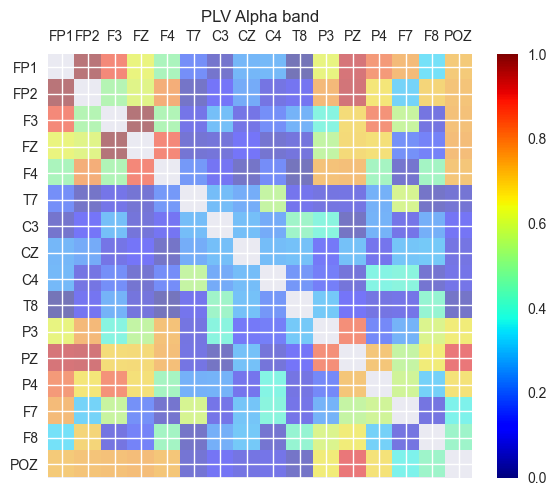

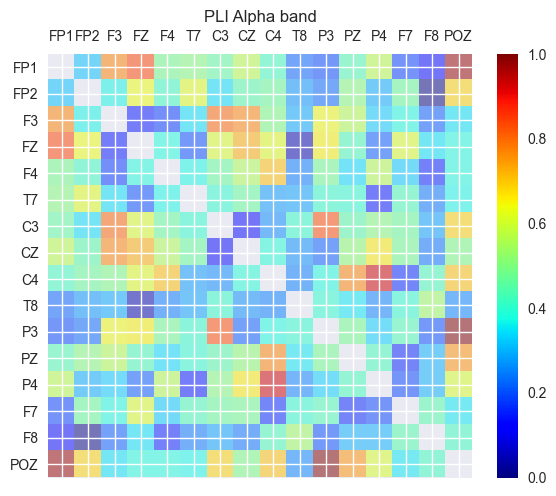

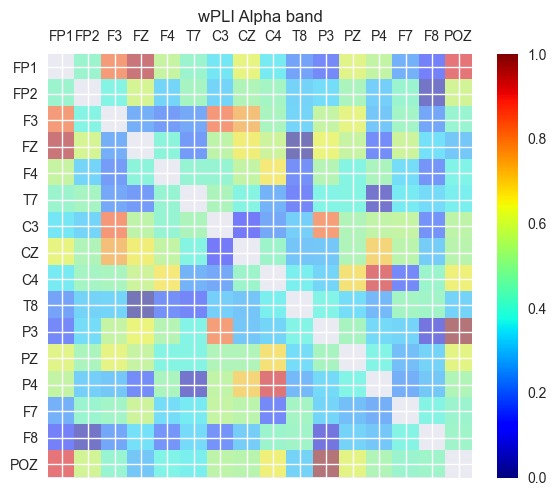

In [9]:
# Compute PLV for different frequency bands
plv_bands = []
for epochs_bands in epochs_filtered:
    plv = phase_connectivity.phase_connectivity(data=epochs_bands,
                                                measure='plv')
    # Average epochs and remove diagonal values
    plv = np.mean(plv,axis=0)
    np.fill_diagonal(plv, np.nan)
    plv_bands.append(plv)

# Compute PLI for different frequency bands
pli_bands = []
for epochs_bands in epochs_filtered:
    pli = phase_connectivity.phase_connectivity(data=epochs_bands,
                                                measure='pli')
    # Average epochs and remove diagonal values
    pli = np.mean(pli,axis=0)
    np.fill_diagonal(pli, np.nan)
    pli_bands.append(pli)

# Compute wPLI for different frequency bands
wpli_bands = []
for epochs_bands in epochs_filtered:
    wpli = phase_connectivity.phase_connectivity(data=epochs_bands,
                                                 measure='wpli')
    # Average epochs and remove diagonal values
    wpli = np.mean(wpli,axis=0)
    np.fill_diagonal(wpli, np.nan)
    wpli_bands.append(wpli)

# Display different adjacency matrices for alpha-filtered signal averaged across epochs

# PLV
fig,ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
ax.matshow(plv_bands[1],cmap='jet', alpha=0.5)
ax.set_title('PLV Alpha band')
ax.set_yticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
ax.set_xticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
fig.colorbar(mapper,ax=ax,fraction=0.046,pad=0.04)

# PLI
fig,ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
ax.matshow(pli_bands[1],cmap='jet', alpha=0.5)
ax.set_title('PLI Alpha band')
ax.set_yticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
ax.set_xticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
fig.colorbar(mapper,ax=ax,fraction=0.046,pad=0.04)

# wPLI
fig,ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")
ax.matshow(wpli_bands[1],cmap='jet', alpha=0.5)
ax.set_title('wPLI Alpha band')
ax.set_yticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
ax.set_xticks(np.arange(len(ch_set.l_cha)),labels=ch_set.l_cha)
fig.colorbar(mapper,ax=ax,fraction=0.046,pad=0.04)

### Visualizing functional connectivity
Once functional connectivity has been computed, it is important to visualize
the resulting networks to better understand the spatial patterns of
interaction between brain regions.

Medusa provides dedicated tools to display **connectivity graphs** over a 2D
scalp layout. These visualizations allow us to quickly assess how different
methods (e.g., PLV, PLI) capture interactions across channels and frequency bands.

In the following cells, we will explore how the connectivity matrices
calculated earlier can be visualized using connectivity plots, providing an
intuitive representation of the brain’s functional networks.

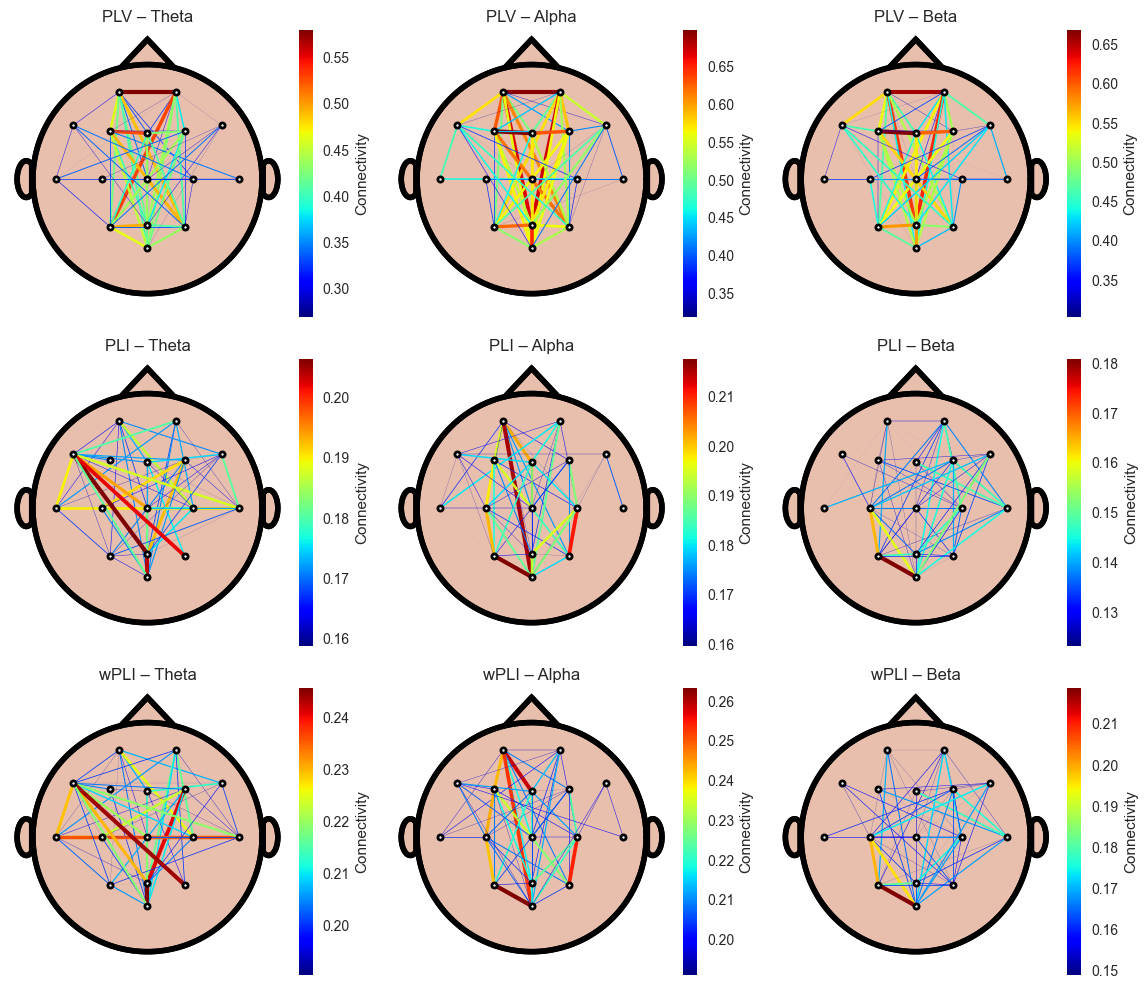

In [21]:
# --- Create a figure with 3x3 subplots ---
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# Connectivity measures and bands
measures = ["PLV", "PLI", "wPLI"]
freq_bands = ["Theta", "Alpha", "Beta"]
adj_matrices = [plv_bands, pli_bands, wpli_bands]

# --- Loop through connectivity methods and bands ---
for r in range(3):
    for c in range(3):
        ax = axes[r, c]
        conn_plot = ConnectivityPlot(
            axes=ax,
            channel_set=ch_set,
            cmap='jet',
            plot_channel_labels=False,
            plot_channel_points=True,
            channel_radius_size=0,
            percentile_th=50  # only strong connections are shown
        )
        conn_plot.update(adj_mat=adj_matrices[r][c])
        ax.set_title(f"{measures[r]} – {freq_bands[c]}")

        # Add individual colorbar
        cbar = fig.colorbar(conn_plot.plot_handles['color-mesh'], ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Connectivity')

plt.tight_layout()
plt.show()


## Amplitude-based connectivity analysis
Amplitude-based functional connectivity metrics quantify the correlation between the **envelope** (amplitude fluctuations) of EEG signals across different channels. These methods are useful for detecting large-scale network interactions driven by signal intensity rather than phase relationships.

In `medusa-kernel`, two amplitude-based connectivity measures are available:

- **Amplitude Envelope Correlation (AEC)** [6]
- **Instantaneous Amplitude Correlation (IAC)** [7]

In this section, we focus on **AEC**, which calculates the Pearson correlation between the envelopes of band-filtered signals. Optionally, the signals can be **orthogonalized** before computing AEC to reduce the influence of **volume conduction**, a common source of spurious connectivity in EEG data.

We will compute AEC for several frequency bands and visualize the results as connectivity matrices and topographic connectivity maps.

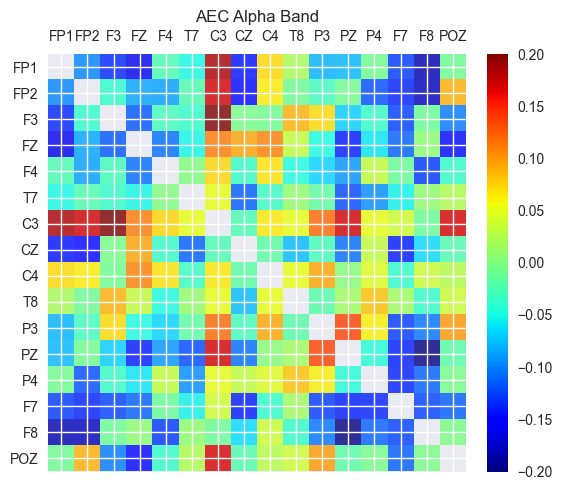

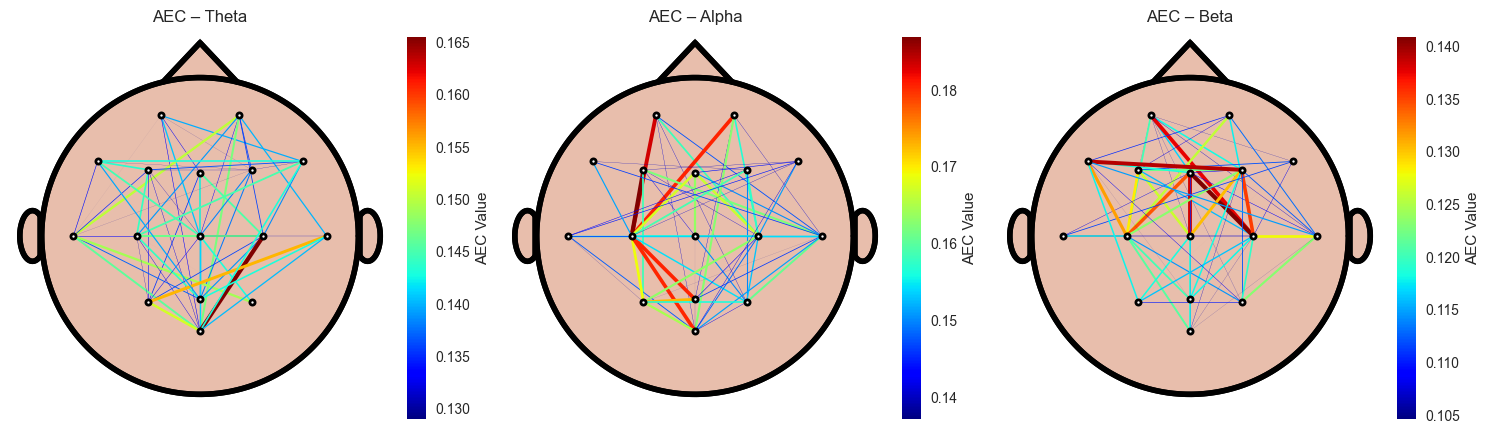

In [20]:
# Compute AEC for different frequency bands
aec_bands = []
for epochs_band in epochs_filtered:
    aec = amplitude_connectivity.aec(data=epochs_band, ort=True)
    aec = np.mean(aec, axis=0)  # Average across epochs
    np.fill_diagonal(aec, np.nan)  # Remove self-connections
    aec_bands.append(aec)

# --- Plot Alpha band AEC as adjacency matrix ---
fig, ax = plt.subplots(figsize=(6, 5))
norm = colors.Normalize(vmin=-0.2, vmax=0.2, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap="jet")

im = ax.matshow(aec_bands[1], cmap='jet', alpha=0.8)
ax.set_title('AEC Alpha Band')
ax.set_yticks(np.arange(len(ch_set.l_cha)))
ax.set_xticks(np.arange(len(ch_set.l_cha)))
ax.set_yticklabels(ch_set.l_cha)
ax.set_xticklabels(ch_set.l_cha)
fig.colorbar(mapper, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- Plot connectivity maps for all frequency bands ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    conn_plot = ConnectivityPlot(
        axes=ax,
        channel_set=ch_set,
        cmap='jet',
        plot_channel_labels=False,
        plot_channel_points=True,
        channel_radius_size=0,
        percentile_th=50  # Show strongest connections
    )
    conn_plot.update(adj_mat=aec_bands[i])
    ax.set_title(f"AEC – {freq_bands[i]}")

    # Add individual colorbar
    cbar = fig.colorbar(conn_plot.plot_handles['color-mesh'], ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("AEC Value")

plt.tight_layout()
plt.show()


## Summary and Next Steps

This concludes the Medusa-Kernel tutorial on **connectivity analysis** in EEG data. Throughout the notebook, we explored:

- Core preprocessing steps for connectivity analysis
- Phase-based methods: **PLV**, **PLI**, and **wPLI**
- Amplitude-based methods: **AEC**
- Effective visualization using topographic connectivity maps

We also demonstrated how to represent adjacency matrices directly on the scalp using the `ConnectivityPlot` class — a powerful tool for understanding inter-channel interactions at a glance.

#### 🚀 What’s Next?

You can extend this analysis by:

- Comparing connectivity patterns across different experimental conditions
- Applying statistical tests or graph-theory measures (e.g., degree, modularity)
- Performing source-level connectivity with inverse solutions
- Exploring dynamic connectivity with time-resolved windows

Thanks for following along — we’ll see you in the next Medusa tutorial!


## References

1. Bachiller, A., Poza, J., Gómez, C., Molina, V., Suazo, V., & Hornero, R. (2015).
   *A comparative study of event-related coupling patterns during an auditory oddball task in schizophrenia.*
   Journal of Neural Engineering, 12(1).

2. Lachaux, J. P., Rodriguez, E., Martinerie, J., & Varela, F. J. (1999).
   *Measuring phase synchrony in brain signals.*
   Human Brain Mapping, 8(4), 194–208.

3. Stam, C. J., Nolte, G., & Daffertshofer, A. (2007).
   *Phase lag index: Assessment of functional connectivity from multichannel EEG and MEG with diminished bias from common sources.*
   Human Brain Mapping, 28(11), 1178–1193.

4. Vinck, M., Oostenveld, R., Van Wingerden, M., Battaglia, F., & Pennartz, C. M. A. (2011).
   *An improved index of phase-synchronization for electrophysiological data in the presence of volume-conduction, noise and sample-size bias.*
   NeuroImage, 55(4), 1548–1565.

5. Liu, Z., Fukunaga, M., de Zwart, J. A., & Duyn, J. H. (2010).
   *Large-scale spontaneous fluctuations and correlations in brain electrical activity observed with magnetoencephalography.*
   NeuroImage, 51(1), 102–111.

6. Tewarie, P., Liuzzi, L., O'Neill, G. C., Quinn, A. J., Griffa, A., Woolrich, M. W., & Brookes, M. J. (2019).
   *Tracking dynamic brain networks using high temporal resolution MEG measures of functional connectivity.*
   NeuroImage, 200, 38–50.
